# AHSN Project
#### Done by:
Safeyah Alshemali - Hannah  Portes - Aparna Muraleekrishnan

#### Based on Paper: 
MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications
[link](https://https://arxiv.org/abs/1704.04861)

#### Authors: 
Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam


### Code Libraries

Below is the process of loading the data of Imagenette. This tensorflow dataset has 10 classes, 9469 training samples, and 3925 validation samples.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import os

# Import Necessary Modules
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras
from keras import datasets, layers, models
from keras.models import Model
from keras.layers import Dense, Dropout, Input, Activation , DepthwiseConv2D, Conv2D, BatchNormalization,  GlobalAveragePooling2D, Activation , Lambda , Reshape
from keras.preprocessing.image import ImageDataGenerator

### Data Processing

The data set we are using is **Imagenette** which is subset of ImageNet dataset of 10 classes only. This dataset fit the resourses (GPUS) and time limitation [link](https://https://www.tensorflow.org/datasets/catalog/imagenette).

In [78]:
# load the data and info from tfds
data, info = tfds.load("imagenette/160px-v2", with_info=True, as_supervised=True)

# then split into training and validation subsets
train_data, valid_data = data['train'], data['validation']

In [79]:
image_size = 160
no_classes = 10
# resize the images to 128 x 128 for faster training 
train_dataset = train_data.map(lambda image, label: (tf.image.resize(image, (image_size, image_size)), label))

validation_dataset = valid_data.map(
    lambda image, label: (tf.image.resize(image, (image_size, image_size)), label))

In [80]:
# print general properties of the dataset for information and to verify attributes
# match what we expect
num_train = train_dataset.__len__().numpy()
num_val = validation_dataset.__len__().numpy()

num_classes = info.features['label'].num_classes
print('Total number of classes in dataset: ', num_classes)
print('Number of training samples: ', num_train)
print('Number of validation samples: ', num_val)

Total number of classes in dataset:  10
Number of training samples:  9469
Number of validation samples:  3925


In [ ]:
# put train and validation into a list, and one hot encode their respective labels
X_train = list(map(lambda x: x[0], train_dataset))
y_train = list(map(lambda x: x[1], train_dataset))


X_valid = list(map(lambda x: x[0], validation_dataset))
y_valid = list(map(lambda x: x[1], validation_dataset))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes)

In [7]:
# Verify shapes
print('Y Train shape: {}'.format(y_train.shape))
print('Y Validation shape: {}'.format(y_valid.shape))
     

Y Train shape: (9469, 10)
Y Validation shape: (3925, 10)


### Data Augmentation

In [ ]:
# Define ImageGen for data augmentation 

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      height_shift_range=0.3)

valid_datagen = ImageDataGenerator(
      rescale=1./255)

train_data = tf.keras.preprocessing.image.NumpyArrayIterator(
    x=np.array(X_train), y=np.array(y_train), image_data_generator=train_datagen,batch_size=32
)

valid_data = tf.keras.preprocessing.image.NumpyArrayIterator(
    x=np.array(X_valid), y=np.array(y_valid), image_data_generator=valid_datagen,batch_size=32
)

In [44]:
del validation_dataset train_dataset X_train y_train

In [53]:
del model_checkpoint_callback64

NameError: ignored

### Data Visualization 

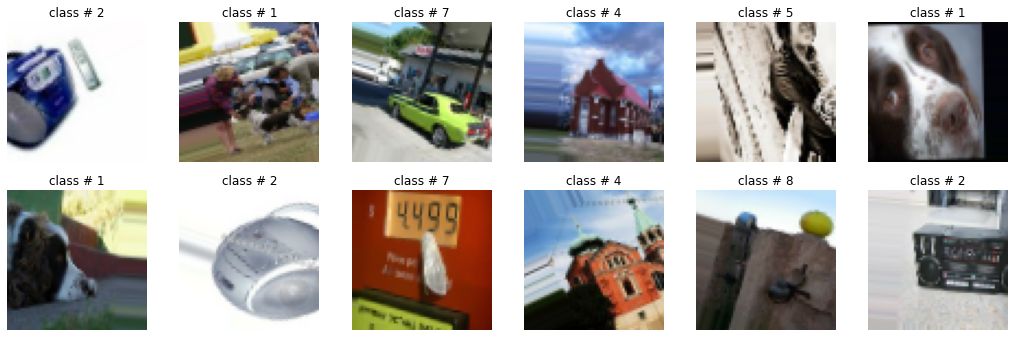

In [9]:
# plot the images
plt.figure(figsize=(18, 18))

num = 0

for i in range(0, 12):
    image,label = next(iter(train_data))
    ax = plt.subplot(6, 6, num + 1)
    plt.imshow(image[0])
    plt.title('class # ' + str(np.argmax(label)))
    plt.axis("off")
    num += 1


### MobileNet Model

The Depthwise Separable Convolution layer

In [23]:
# Function for Depth-wise Convolution Layer
def DepthWiseConv(kernal_size, stride, x):
    result = DepthwiseConv2D(kernal_size, strides=stride , padding='same')(x)
    result = BatchNormalization()(result)
    result = Activation('relu')(result)
    return result

In [24]:
# Function for Point-wise Convolution Layer
def PointWiseConv(filters,alpha,kernal_size, stride, x):
    result = Conv2D(int(alpha*filters), kernel_size=kernal_size, strides=stride)(x)
    result = BatchNormalization()(result)
    result = Activation('relu')(result)
    return result

Model Creation

In [65]:
def create_Reduced_MobileNet_model(input_shape, alpha ,no_classes):
    
    #first layer (Conv/s2)
    input = Input(shape= input_shape)
    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2) ,padding='same', use_bias=False)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #second layer (Conv dw/s1) + (Conv /s1)
    x = DepthWiseConv((3,3), (1,1), x)
    x = PointWiseConv(64,1,(1, 1), (1, 1) ,x)

    #third layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(128,1,(1, 1), (1, 1) ,x)
    
    #4th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(256,1,(1, 1), (1, 1) ,x)

    #5th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(512,1,(1, 1), (1, 1) ,x)

    #6th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(1024,1,(1, 1), (1, 1) ,x)

    #7th layer dropout 
    x = Dropout(0.2)(x)

    #8th layer: Avg Pooling
    x = GlobalAveragePooling2D()(x) 

    #9th layer Dense layer
    out = Dense(no_classes,activation='softmax')(x)

    model = Model(input, out, name='mobilenet')

    return model    

Fitting and Training the Model

In [66]:
MobileNet = create_Reduced_MobileNet_model((image_size,image_size,3),1,no_classes)
MobileNet.summary()


Model: "mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 32)        864       
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 activation_33 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 depthwise_conv2d_15 (Depthw  (None, 64, 64, 32)       320       
 iseConv2D)                                                      
                                                                 
 batch_normalization_34 (Bat  (None, 64, 64, 32)       12

In [14]:
# Input Resolution 64 x 64
# Tracking Start Time
start = time.time()

MobileNet.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# Saving the result
checkpoint_filepath = './tmp/checkpoint64'
model_checkpoint_callback64 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,verbose=1, monitor='accuracy')
history64 = MobileNet.fit(train_data, epochs=25, validation_data=valid_data, callbacks=[model_checkpoint_callback64], shuffle=True)

# Tracking End Time
end = time.time()

MobileNet.load_weights(checkpoint_filepath)
print('Time Consumption: ', end-start)

Epoch 1/25
296/296 [==============================] - ETA: 0s - loss: 1.9068 - accuracy: 0.3465
Epoch 1: saving model to ./tmp/checkpoint64
296/296 [==============================] - 24s 49ms/step - loss: 1.9068 - accuracy: 0.3465 - val_loss: 2.5257 - val_accuracy: 0.0986
Epoch 2/25
295/296 [============================>.] - ETA: 0s - loss: 1.5741 - accuracy: 0.4678
Epoch 2: saving model to ./tmp/checkpoint64
296/296 [==============================] - 14s 47ms/step - loss: 1.5739 - accuracy: 0.4677 - val_loss: 1.8970 - val_accuracy: 0.3098
Epoch 3/25
295/296 [============================>.] - ETA: 0s - loss: 1.4143 - accuracy: 0.5319
Epoch 3: saving model to ./tmp/checkpoint64
296/296 [==============================] - 14s 47ms/step - loss: 1.4132 - accuracy: 0.5322 - val_loss: 1.4380 - val_accuracy: 0.5552
Epoch 4/25
295/296 [============================>.] - ETA: 0s - loss: 1.2992 - accuracy: 0.5715
Epoch 4: saving model to ./tmp/checkpoint64
296/296 [==============================] 

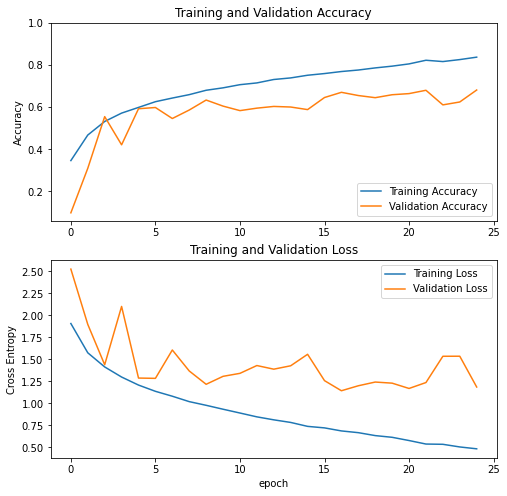

In [15]:
#plot the results 
acc = history64.history['accuracy']
val_acc = history64.history['val_accuracy']

loss = history64.history['loss']
val_loss = history64.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')

plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [57]:
!rm -rf ./tmp/*
!ls ./tmp

In [27]:
# Input Resolution 96 x 96
# Tracking Start Time
start = time.time()

MobileNet.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# Saving the result
checkpoint_filepath = './tmp/checkpoint96'
model_checkpoint_callback64 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,verbose=1, monitor='accuracy')
history96 = MobileNet.fit(train_data, epochs=25, validation_data=valid_data, callbacks=[model_checkpoint_callback64], shuffle=True)

# Tracking End Time
end = time.time()

MobileNet.load_weights(checkpoint_filepath)
print('Time Consumption: ', end-start)

Epoch 1/25
296/296 [==============================] - ETA: 0s - loss: 1.7785 - accuracy: 0.3952
Epoch 1: saving model to ./tmp/checkpoint96
296/296 [==============================] - 27s 85ms/step - loss: 1.7785 - accuracy: 0.3952 - val_loss: 3.1060 - val_accuracy: 0.1017
Epoch 2/25
296/296 [==============================] - ETA: 0s - loss: 1.4626 - accuracy: 0.5141
Epoch 2: saving model to ./tmp/checkpoint96
296/296 [==============================] - 42s 141ms/step - loss: 1.4626 - accuracy: 0.5141 - val_loss: 2.2289 - val_accuracy: 0.2596
Epoch 3/25
296/296 [==============================] - ETA: 0s - loss: 1.2844 - accuracy: 0.5739
Epoch 3: saving model to ./tmp/checkpoint96
296/296 [==============================] - 31s 103ms/step - loss: 1.2844 - accuracy: 0.5739 - val_loss: 1.3929 - val_accuracy: 0.5664
Epoch 4/25
296/296 [==============================] - ETA: 0s - loss: 1.1967 - accuracy: 0.6076
Epoch 4: saving model to ./tmp/checkpoint96
296/296 [==============================

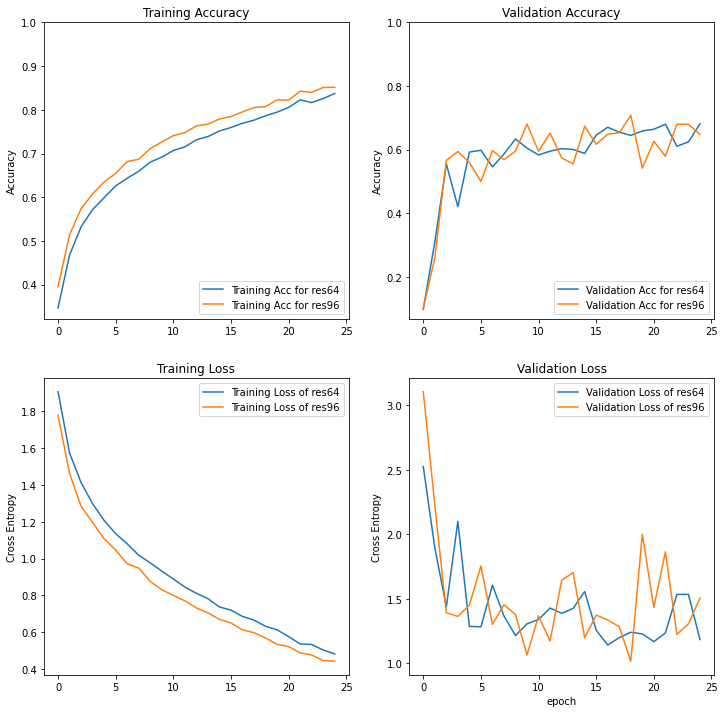

In [46]:
#acc1 = history96.history['accuracy']
#val_acc1 = history96.history['val_accuracy']

#loss1 = history96.history['loss']
#val_loss1 = history96.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Acc for res64')
plt.plot(acc1, label='Training Acc for res96')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(val_acc, label='Validation Acc for res64')
plt.plot(val_acc1, label='Validation Acc for res96')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Validation Accuracy')

plt.subplot(2, 2, 3)
plt.plot(loss, label='Training Loss of res64')
plt.plot(loss1, label='Training Loss of res96')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training Loss')

plt.subplot(2, 2, 4)
plt.plot(val_loss, label='Validation Loss of res64')
plt.plot(val_loss1, label='Validation Loss of res96')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Validation Loss')

plt.xlabel('epoch')
plt.show()

In [68]:
!rm -rf ./tmp/*

In [71]:
# Input Resolution 128 x 128
# Tracking Start Time
start = time.time()

MobileNet.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# Saving the result
checkpoint_filepath = './tmp/checkpoint128'
model_checkpoint_callback128 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,verbose=1, monitor='accuracy')
history128 = MobileNet.fit(train_data, epochs=25, validation_data=valid_data, callbacks=[model_checkpoint_callback128], shuffle=True)

# Tracking End Time
end = time.time()

MobileNet.load_weights(checkpoint_filepath)
print('Time Consumption: ', end-start)

Epoch 1/25
296/296 [==============================] - ETA: 0s - loss: 1.7432 - accuracy: 0.4050
Epoch 1: saving model to ./tmp/checkpoint128
296/296 [==============================] - 39s 128ms/step - loss: 1.7432 - accuracy: 0.4050 - val_loss: 3.5203 - val_accuracy: 0.0986
Epoch 2/25
296/296 [==============================] - ETA: 0s - loss: 1.4152 - accuracy: 0.5277
Epoch 2: saving model to ./tmp/checkpoint128
296/296 [==============================] - 38s 128ms/step - loss: 1.4152 - accuracy: 0.5277 - val_loss: 2.0507 - val_accuracy: 0.2958
Epoch 3/25
296/296 [==============================] - ETA: 0s - loss: 1.2449 - accuracy: 0.5910
Epoch 3: saving model to ./tmp/checkpoint128
296/296 [==============================] - 38s 128ms/step - loss: 1.2449 - accuracy: 0.5910 - val_loss: 1.4086 - val_accuracy: 0.5493
Epoch 4/25
296/296 [==============================] - ETA: 0s - loss: 1.1383 - accuracy: 0.6346
Epoch 4: saving model to ./tmp/checkpoint128
296/296 [=========================

In [76]:
!rm -rf ./tmp/*

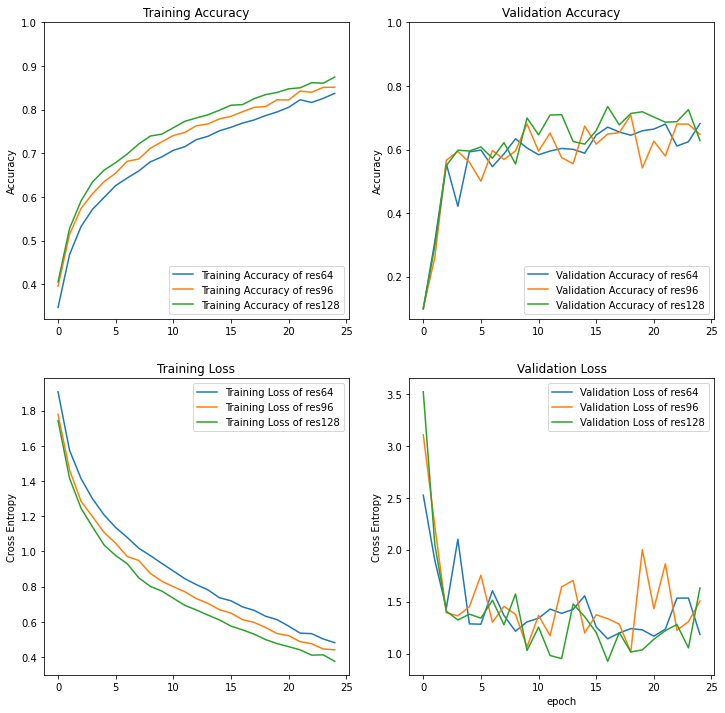

In [74]:
acc2 = history128.history['accuracy']
val_acc2 = history128.history['val_accuracy']

loss2 = history128.history['loss']
val_loss2 = history128.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy of res64')
plt.plot(acc1, label='Training Accuracy of res96')
plt.plot(acc2, label='Training Accuracy of res128')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(val_acc, label='Validation Accuracy of res64')
plt.plot(val_acc1, label='Validation Accuracy of res96')
plt.plot(val_acc2, label='Validation Accuracy of res128')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Validation Accuracy')

plt.subplot(2, 2, 3 )
plt.plot(loss, label='Training Loss of res64')
plt.plot(loss1, label='Training Loss of res96')
plt.plot(loss2, label='Training Loss of res128')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training Loss')

plt.subplot(2, 2, 4 )
plt.plot(val_loss, label='Validation Loss of res64')
plt.plot(val_loss1, label='Validation Loss of res96')
plt.plot(val_loss2, label='Validation Loss of res128')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Validation Loss')

plt.xlabel('epoch')
plt.show()

In [75]:
del history128, model_checkpoint_callback128, model_checkpoint_callback64

### CNN Model

Standard Convolution Layer 

In [ ]:
def standard_Conv(filter,kernal_size, stride, x):
  x = Conv2D(filter, kernel_size=kernal_size, strides=stride ,padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

Model Creation

In [ ]:
def create_CNN_model(input_shape ,no_classes):
    
    filters = [32,64,128,256,512,1024]
    strides = [2,1,2,2,2,2]
    layers = len(filters)
    
    x = Input(shape= input_shape)

    for i in range(layers):
      x = Conv2D(filters[i], kernel_size=(3, 3), strides=(strides[i], strides[i]) ,padding='same', use_bias=False)(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

    # Dropout Layer 
    x = Dropout(0.2)(x)

    # Avg Pooling layer
    x = GlobalAveragePooling2D()(x) 

    # Dense layer
    out = Dense(no_classes,activation='softmax')(x)

    model = Model(input, out, name='mobilenet')

    return model    

Fitting and Training The Model

In [ ]:
MobileNet = create_Reduced_MobileNet_model((image_size,image_size,3),1,no_classes)
MobileNet.summary()


In [ ]:
# Tracking Start Time
start = time.time()

MobileNet.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# Saving the result
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,verbose=1, monitor='accuracy')
history = MobileNet.fit(train_data, epochs=25, validation_data=valid_data, callbacks=[model_checkpoint_callback], shuffle=True)

# Tracking End Time
end = time.time()

MobileNet.load_weights(checkpoint_filepath)
print('Time Consumption: ', end-start)

In [ ]:
#plot the results 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')

plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()